In [21]:
import pandas as pd
import sys
import nltk
from nltk.corpus import alpino as alp
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.tag.util import tuple2str
import re 
import pickle
import glob
import numpy as np
import seaborn as sns
from sklearn.externals import joblib
pd.set_option('display.max_colwidth', 250)
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

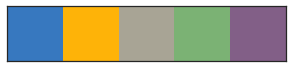

In [3]:
#format plots
sns.set(style='white', context='notebook', font_scale=1.5, 
        rc={'font.sans-serif': 'DejaVu Sans', 'lines.linewidth': 2.5})

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
sns.palplot(sns.xkcd_palette(colors))

#create a color map
blog_blue = '#64C0C0'
blue_cmap = sns.light_palette(blog_blue, as_cmap=True)

# Write pickles

In [4]:
def write_pickle(output_, input_):
    '''
    output specifies where you want to write which file 
    input defines which variable you want to write as a pickle
    '''
    n_bytes = 2**31
    max_bytes = 2**31 - 1
    data = bytearray(n_bytes)
    bytes_out = pickle.dumps(input_)
    with open(output_, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])
            

def read_pickle(name):
    n_bytes = 2**31
    max_bytes = 2**31 - 1
    data = bytearray(n_bytes)
    bytes_in = bytearray(0)
    input_size = os.path.getsize(name)
    with open(name, 'rb') as f_in:
        for _ in range(0, input_size, max_bytes):
            bytes_in += f_in.read(max_bytes)
    return pickle.loads(bytes_in)

# Extract Recipes


In [4]:
import os
import glob
import pandas as pd
import warnings
from sklearn.externals import joblib
import numpy as np
from nltk.tokenize import sent_tokenize, RegexpTokenizer
import re

warnings.filterwarnings('ignore')

In [6]:
def extract_recipes(name):
    '''
    options for names include trouw, volkskrant, parool, or nrc
    '''
    
    path = 'data/' + name
    allFiles = glob.glob(path + "/*.tsv")
    if name == 'nrc':
        df = pd.concat((pd.read_csv(f, delimiter='\t') for f in allFiles))
    else:
        df = pd.concat((pd.read_csv(f, delimiter='\t', header=None) for f in allFiles))
        df.columns = ['date', 'page', 'size', 'min_x', 'min_y', 'max_x', 'max_y', 'w', 'h', 'image_url', 'ocr_url', 'ocr']
    print("imported " + name + " articles")
    drop_cols = ['min_x', 'min_y', 'max_x', 'max_y', 'image_url']
    df = df.drop(drop_cols, axis=1)
    df = df.dropna(subset =['ocr']) # remove lines with empty ocr field
    df = df[~df['date'].str.contains('date')] #remove duplicate header rows
    # remove files that contain error msg 
    excludes = ['objecttype', 'file directory not found']
    df = df[~df['ocr'].astype(str).str.contains('|'.join(excludes))] #remove rows with restricted error msg
    print("Total number of pages in " + name + " dataset: {}".format(df.groupby('date')['page'].unique().count()))
    print("Total number of articles in " + name + " dataset: {}".format(df.shape[0]))
    
    # only select articles that contain specific query words
    df = df[df['ocr'].str.contains(r'\b(recept|recepten)\b',case=False)]
    df = df[df['ocr'].str.contains(r'\b(gram|kilogram|pond|keuken|koken|kook|bakken|eetlepel|gerecht|theelepel|snijden)\b',case=False)]
    print("Recipes " + name + " Extracted")
    print("Total number of recipes in " + name + " dataset: {}".format(df.shape[0]))
    #df_recipes.to_csv(name + 'raw_recipes.csv')
    return df

In [8]:
def load_df(name):
    '''
    options for names include trouw, volkskrant, parool, or nrc
    '''
    
    path = 'data/' + name
    allFiles = glob.glob(path + "/*.tsv")
    if name == 'nrc':
        df = pd.concat((pd.read_csv(f, delimiter='\t') for f in allFiles))
    else:
        df = pd.concat((pd.read_csv(f, delimiter='\t', header=None) for f in allFiles))
        df.columns = ['date', 'page', 'size', 'min_x', 'min_y', 'max_x', 'max_y', 'w', 'h', 'image_url', 'ocr_url', 'ocr']
    print("imported " + name + " articles")
    drop_cols = ['min_x', 'min_y', 'max_x', 'max_y', 'image_url']
    df = df.drop(drop_cols, axis=1)
    df = df.dropna(subset =['ocr']) # remove lines with empty ocr field
    df = df[~df['date'].str.contains('date')] #remove duplicate header rows
    return df

In [ ]:
nrc_recipes = extract_recipes('nrc')
nrc_recipes.to_csv('./data/nrc_raw_recipes.csv')

vk_recipes = extract_recipes('vk')
vk_recipes.to_csv('./data/vk_raw_recipes.csv')

trouw_recipes = extract_recipes('trouw')
trouw_recipes.to_csv('./data/trouw_raw_recipes.csv')

parool_recipes = extract_recipes('parool')
parool_recipes.to_csv('./data/parool_raw_recipes.csv')

# Create Clean Set of Recipes from Annotated Data

I have handcoded the actual recipes in the extracted recipes extracting using the function extract_recipe.

## NRC

In [14]:
nrc_recipes = pd.read_csv('./data/nrc_clean_recipes.csv', index_col=0)
nrc_recipes['date'] = pd.to_datetime(nrc_recipes['date'])
nrc_recipes = nrc_recipes.set_index(['date'], drop=False)
nrc_recipes.recipe.value_counts()
nrc_recipes['recipe'][nrc_recipes['recipe'] == 1].resample('12M').count().plot(title = 'Correct / False Recipes in NRC', figsize=(10,5))
nrc_recipes['recipe'][nrc_recipes['recipe'] == 0].resample('12M').count().plot()

1.0    1913
0.0     753
Name: recipe, dtype: int64

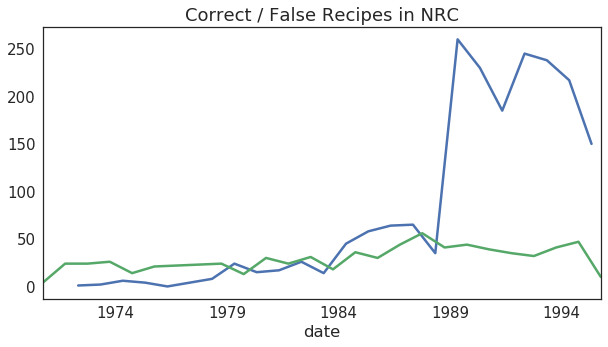

In [155]:
nrc_recipes['recipe'][nrc_recipes['recipe'] == 1].resample('12M').count().plot(title = 'Correct / False Recipes in NRC', figsize=(10,5))
nrc_recipes['recipe'][nrc_recipes['recipe'] == 0].resample('12M').count().plot()

In [156]:
nrc_correct = nrc_recipes[nrc_recipes['recipe'] == 1]
nrc_false = nrc_recipes[nrc_recipes['recipe'] == 0]

In [ ]:
#extract sample from newspaper articles
nrc_df = load_df('nrc')
nrc_sample = nrc_df[(~nrc_df.ocr_url.isin(nrc_correct.ocr_url))].sample(n=6000, random_state=10)

## Volkskrant

In [13]:
vk_recipes = pd.read_csv('./data/vk_clean_recipes.csv', index_col=0)
vk_recipes['date'] = pd.to_datetime(vk_recipes['date'])
vk_recipes = vk_recipes.set_index(['date'], drop=False)
vk_recipes.recipe.value_counts()
vk_recipes['recipe'][vk_recipes['recipe'] == 1].resample('12M').count().plot()

1    1526
0     796
Name: recipe, dtype: int64

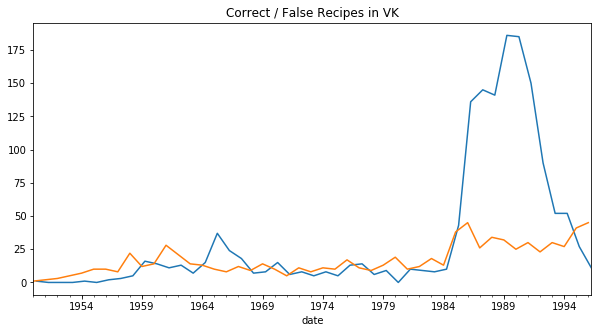

In [31]:
vk_recipes['recipe'][vk_recipes['recipe'] == 1].resample('12M').count().plot(title = 'Correct / False Recipes in VK', figsize=(10,5))
vk_recipes['recipe'][vk_recipes['recipe'] == 0].resample('12M').count().plot()

In [161]:
vk_recipes['title'] = 'volkskrant'
vk_correct = vk_recipes[vk_recipes['recipe'] == 1]
vk_false = vk_recipes[vk_recipes['recipe'] == 0]
vk_recipes.recipe.value_counts()

1    1526
0     796
Name: recipe, dtype: int64

In [ ]:
#extract sample from newspaper articles
vk_df = load_df('nrc')
vk_sample = vk_df[(~vk_df.ocr_url.isin(vk_correct.ocr_url))].sample(n=6000, random_state=10)

# Trouw

In [3]:
trouw_recipes = pd.read_csv('./data/trouw_clean_recipes.csv', index_col=0)
trouw_recipes['date'] = pd.to_datetime(trouw_recipes['date'])
trouw_recipes = trouw_recipes.set_index(['date'], drop=False)
trouw_recipes.recipe.value_counts()
trouw_recipes['recipe'][trouw_recipes['recipe'] == 1].resample('12M').count().plot(title = 'Correct / False Recipes in Trouw', figsize=(10,5))
trouw_recipes['recipe'][trouw_recipes['recipe'] == 0].resample('12M').count().plot()

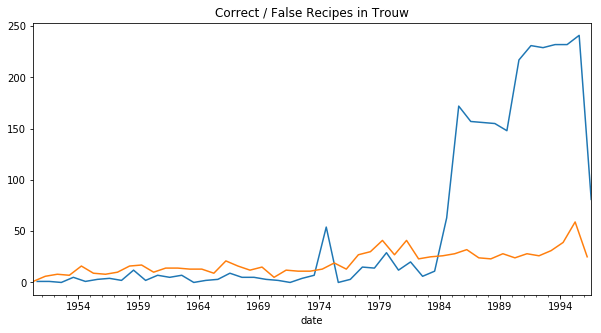

In [24]:
trouw_recipes['recipe'][trouw_recipes['recipe'] == 1].resample('12M').count().plot(title = 'Correct / False Recipes in Trouw', figsize=(10,5))
trouw_recipes['recipe'][trouw_recipes['recipe'] == 0].resample('12M').count().plot()

In [25]:
trouw_recipes['title'] = 'trouw'
trouw_correct = trouw_recipes[trouw_recipes['recipe'] == 1]
trouw_false = trouw_recipes[trouw_recipes['recipe'] == 0]
trouw_recipes.recipe.value_counts()

1    2568
0     926
Name: recipe, dtype: int64

In [ ]:
#extract sample from newspaper articles
trouw_df = load_df('trouw')
trouw_sample = trouw_df[(~trouw_df.ocr_url.isin(trouw_correct.ocr_url))].sample(n=6000, random_state=10)

## Parool recipes

### Import Clean Set

In [4]:

parool_recipes = pd.read_csv('./data/parool_clean_recipes.csv', index_col=0, header=None, names=cols)
parool_recipes['date'] = parool_recipes['date'].astype('datetime64[ns]')
parool_recipes['date'] = pd.to_datetime(parool_recipes['date'])
parool_recipes = parool_recipes.set_index(['date'], drop=False)
parool_recipes.recipe.value_counts()

1    1481
0     971
Name: recipe, dtype: int64

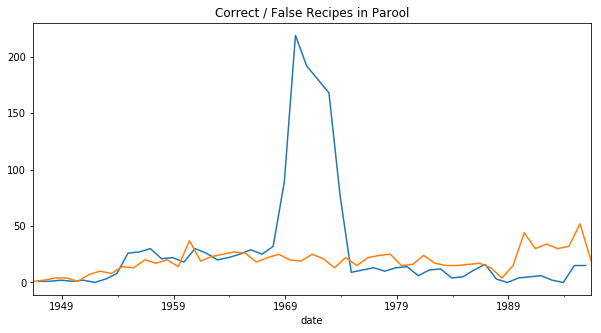

In [30]:
parool_recipes['recipe'][parool_recipes['recipe'] == 1].resample('12M').count().plot(title = 'Correct / False Recipes in Parool', figsize=(10,5))
parool_recipes['recipe'][parool_recipes['recipe'] == 0].resample('12M').count().plot()

In [84]:
parool_recipes['title'] = 'parool'
parool_correct = parool_recipes[parool_recipes['recipe'] == 1]
parool_false = parool_recipes[parool_recipes['recipe'] == 0]

In [ ]:
#extract sample from newspaper articles
parool_df = load_df('parool')
parool_sample = parool_df[(~parool_df.ocr_url.isin(parool_correct.ocr_url))].sample(n=6000, random_state=10)

# Final dataset

In [85]:
# dataset with articles falsely queried as recipes
recipes_removed = pd.concat([vk_false, parool_false, trouw_false, nrc_false])
recipes_removed['type'] = 'articles'
drop_cols = ['h', 'publication_day', 'publication_month', 'publication_year', 'recipe', 'size', 'w']
recipes_removed = recipes_removed.drop(drop_cols, axis=1).reset_index(drop=True)

NameError: name 'trouw_false' is not defined

In [152]:
# dataset with recipes
recipes = pd.concat([vk_correct, parool_correct, trouw_correct, nrc_correct])
recipes['type'] = 'recipes'
recipes = recipes.drop(drop_cols, axis=1).reset_index(drop=True)

NameError: name 'vk_correct' is not defined

In [ ]:
# random articles from three newspapers
random_articles = pd.concat([nrc_sample, vk_sample, trouw_sample, parool_sample])
random_articles['type'] = 'articles'
random_articles = random_articles.drop(['h', 'size', 'w'], axis=1).reset_index(drop=True)

In [ ]:
#final dataset
dataset = pd.concat([recipes_removed, recipes, random_articles])
dataset.ocr = dataset.ocr.astype(str)

#remove query words from articles to improve classifier
stop_words = ['recept', 'recepten', 'gram', 
             'kilogram', 'pond' ,'keuken', 'koken', 'kook',
             'bakken', 'eetlepel', 'gerecht', 'theelepel', 'snijden']

dataset['ocr_without_stopwords'] = dataset['ocr'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))
dataset = dataset.dropna()

In [ ]:
#export dataset to pickle
write_pickle('./data/recipe_dataset.pkl', dataset)

## Classify Recipes

In [ ]:
def classify_recipes(df):
    clf = joblib.load('./models/ah_tags.pkl')
    lb = joblib.load('./models/ah_classes.pkl')
    X_test = df.ocr
    predictions = clf.predict(X_test)
    all_predicted_tags = []
    for index in range(predictions.shape[0]):
        all_predicted_tags.append(', '.join(list(lb.classes_[np.where(predictions[index, :] == 1)[0]])))
    tags = pd.Series(all_predicted_tags)
    df['predicted_tags'] = tags.values
    print("tags predicted!")
    return df

## Extract Ingredients and Quantities from Recipes

* to do: add new list of ingredients plus quantities.

In [ ]:
# POS tagging could be removed possibly, this would also simplify the regexes 
# This code can be much faster when using pandas vectorization 

def import_list():
## IMPORT NEW LIST
# import the list of ingredients 
# Complete list seems to result in a slightly higher recall  
	list_ = []
#	with open("ingredient_list.csv", 'r') as x: # yes it's hard coded, not so neat
	with open("./data/unique_ingredients.csv", 'r') as x: # yes it's hard coded, not so neat
		for line in x:
			line = line.rstrip()
			elems = line.split("_")
			if len(elems) < 2:
				list_.append(elems[0])
	return(list_)

def preprocess_text(t):
	tagged_list_ = []
	tokenizer = RegexpTokenizer(r'\w+')
	words = tokenizer.tokenize(t)
	words = " ".join(words)
	return(words)

def detect_ingredients(text,list_):
	ingredients = [] 
	for x in list_:
		x = " " + x +" "
		ingredient = re.search(x, text)
		if ingredient:
			 ingredients.append(ingredient.group().rstrip())
		unique_ingredients = set(ingredients)        
	return(unique_ingredients)


def detect_quantities(text,ing_list):
# Loop through the text again with the ingredients and see if you can find a quantity 
	quantities_ingr = [] 
	ingredients_matched_copy = []
    metrics = []
    with open("./data/unique_units.csv", 'r') as x: # yes it's hard coded, not so neat
		for line in x:
			line = line.rstrip()
			metrics.append(line)
	return(metrics)
	#metrics = ['dl', 'gr', 'gram', 'eetlepel', 'el', 'theelepel', 'tl', 'snufje', 'snuf', 'ml', 'g']
	for y in ing_list:
		for z in metrics: 
			my_regex = "[0-9]* " + z + y + "|[0-9]* " + z + y + "|[0-9]+" + y
			quantity = re.search(my_regex, text)
			if quantity:
				quantities_ingr.append(quantity.group())
				ingredients_matched_copy.append(y)
	# Do something smart so you get one list with items for which you found quantities and items for which you didn't                
	copy_ingrs = ing_list
	for item in ingredients_matched_copy:
		try:
			copy_ingrs.remove(item) 
		except:
			pass        
	merged = list(copy_ingrs) + quantities_ingr
	unique = set(merged)
	return(unique)

def extract_ingredients(t):
    processed_text = preprocess_text(t)
    found_ingredients = detect_ingredients(processed_text, allerhande_ingredients)
    ingr_and_quant = detect_quantities(processed_text, found_ingredients)
    return(ingr_and_quant)

In [ ]:
#classify recipes

nrc_recipes = classify_recipes(nrc_recipes)
volkskant_recipes = classify_recipes(vk_recipes)
trouw_recipes = classify_recipes(trouw_recipes)
parool_recipes = classify_recipes(parool_recipes)

In [ ]:
#extract ingredients and add them to the df
allerhande_ingredients = import_list()
nrc_recipes['ingredients_quantities'] = nrc_recipes.ocr.apply(extract_ingredients)
vk_recipes['ingredients_quantities'] = vk_recipes.ocr.apply(extract_ingredients)
trouw_recipes['ingredients_quantities'] = trouw_recipes.ocr.apply(extract_ingredients)
parool_recipes['ingredients_quantities'] = parool_recipes.ocr.apply(extract_ingredients)

In [ ]:
nrc_recipes.to_csv('./data/nrc_recipes.csv')
vk_recipes.to_csv('./data/vk_recipes.csv')
trouw_recipes.to_csv('./data/trouw_recipes.csv')
parool_recipes.to_csv('./data/parool_recipes.csv')

In [ ]:
nrc_recipes.to_json("./data/nrc_recipes.json", orient="records")
vk_recipes.to_json("./data/vk_recipes.json", orient="records")
trouw_recipes.to_json("./data/trouw_recipes.json", orient="records")
parool_recipes.to_json("./data/parool_recipes.json", orient="records")

In [ ]:
x